# Dymas micromagnetic software examples
Author: Diego González Chávez  
email : diegogch@cbpf.br


## FMR Standar Problem

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#Dymas
import sys
sys.path.append("../") #Path to dymas package
import dymas

#Ubermag
import discretisedfield as df
import micromagneticmodel as mm

In [2]:
#FMR Standar Problem definition in ubermag

lx = ly = 120e-9  # x and y dimensions of the sample(m)
lz = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
Hangle = 35*np.pi/180
H = 8e4 * np.array([np.cos(Hangle), np.sin(Hangle), 0])
alpha = 0.008  # Gilbert damping
gamma0 = 2.210173e5

mesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=(dx, dy, dz))

system = mm.System(name='FMR_StdProb')

system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=H)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms) # initial value

In [3]:
#Import the ubermag system
S = dymas.System.fromUbermagSystem(system)

#Find the equilibrium position
dymas.Minimize(S)

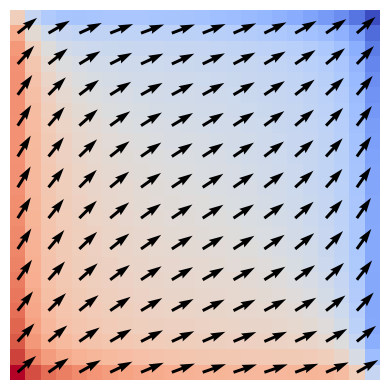

In [4]:
# Plot the equibrim state
plt.close('Static M')
fig = plt.figure('Static M', (4,4))
sp = fig.add_subplot(1,1,1)

#Reconstruct m into a 3D array
m3D = np.zeros((*S.mesh_n, 3))
m3D[~S.mask] = S.m

xs = np.arange(0, S.mesh_n[0], 1)
ys = np.arange(0, S.mesh_n[1], 1)
X, Y = np.meshgrid(xs, ys)

#Plot z direction of the first layer as color 
sp.imshow(m3D[:,:,0,2].T, 
       origin = 'lower', 
       cmap = 'coolwarm',
       interpolation = 'none',
       aspect = 1
       )

#Use x,y directions of the first layer for arrows 
sp.quiver(X[::2,::2], Y[::2,::2], 
          m3D[::2,::2,0,0].T, m3D[::2,::2,0,1].T, 
          width=0.008, scale=15)
sp.set_xticks([])
sp.set_yticks([])
plt.tight_layout()

In [5]:
#Calculate D operators
dymas.D_operator(S)

#Solve the eigenproblem of the rotated version of the D operator
eig_vals, eig_vects = np.linalg.eig(S.RDRz)

In [6]:
#Short and show the frequencies

fr = np.real(eig_vals/(2j*np.pi))
fr = fr[fr.argsort()]
fr = fr[fr>=0]
for i in range(15):
    print('%2d:  %0.3f GHz' %(i,fr[i]/1E9))

 0:  8.270 GHz
 1:  9.405 GHz
 2:  10.840 GHz
 3:  11.237 GHz
 4:  12.003 GHz
 5:  13.057 GHz
 6:  13.827 GHz
 7:  14.288 GHz
 8:  15.341 GHz
 9:  15.931 GHz
10:  16.746 GHz
11:  17.257 GHz
12:  17.482 GHz
13:  18.443 GHz
14:  19.854 GHz


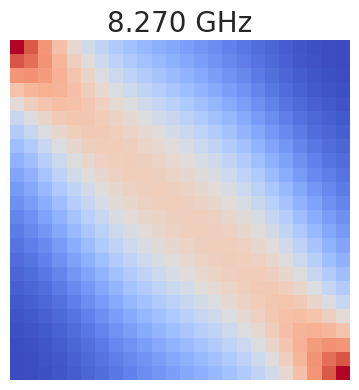

In [7]:
##Plot the eigenvalue amplitudes in the 3d space.

f_i = 0 # number of mode to plot

#Get the mode index
fs_hi = np.real(eig_vals/(2j*np.pi))
fi = np.abs(fs_hi - fr[f_i]).argmin()

#Get the vector
e_vect_hi_fi = eig_vects[:,fi].reshape(S.R[:,0,:].shape)

#Reconstruct the mode in 3D space
dm3D = np.zeros((*S.mesh_n, 3), dtype='complex')
dm3D[~S.mask] = np.einsum('iu,iau->ia',e_vect_hi_fi, S.R)
dm3D[S.mask] = np.nan 

#Take the same component of the proposal paper.
plotData = np.abs(dm3D[:,:,:,1].mean(axis=2))

plt.close('Mode X')
fig = plt.figure('Mode X', (6,4))
plt.imshow(plotData.T, 
        origin = 'lower', 
        cmap = 'coolwarm',
        interpolation = 'none',
        aspect = 1
        )
plt.title('%0.3f GHz' % (fs_hi[fi]/1E9))
plt.xticks([])
plt.yticks([])
plt.tight_layout()


### Change of basis

In [8]:
from numpy.polynomial.legendre import legval3d
import itertools

# size of the grid base
nBox = S.m.shape[0]

# "normalized" Positions on the grid
xs = -1 + 2*(np.arange(S.mask.shape[0])+0.5)/S.mask.shape[0]
ys = -1 + 2*(np.arange(S.mask.shape[1])+0.5)/S.mask.shape[1]
zs = -1 + 2*(np.arange(S.mask.shape[2])+0.5)/S.mask.shape[2]


# Coordinates of the grid:
Xg, Yg, Zg = np.meshgrid(xs, ys, zs, indexing='ij')

# Legnedre polinomials
nXY = 10  # number of polinomials for each X and Y axis

# get coeficients for leggrid3d Pn(x)Pm(y)Pl(z) for any n+m+l
c_full = np.zeros([nXY, nXY, 2, 2*nXY**2])  # (max n, max m, max l, size of base)
for i, j, k in itertools.product(range(nXY), range(nXY), range(2)):
    c_full[i, j, k, i*nXY*2 + j*2 + k] = 1

# get coeficients for leggrid3d Pn(x)Pm(y)Pl(z) for n+m+l = even
c_even = np.zeros([nXY, nXY, 2, 2*nXY**2])  # (max n, max m, max l, size of base)
for i, j, k in itertools.product(range(nXY), range(nXY), range(2)):
    c_even[i, j, k, i*nXY*2 + j*2 + k] = ((i+j+k) % 2 != 0)*1
# drop all 0 elements
c_even = c_even[:, :, :, c_even.sum(axis=(0, 1, 2)) != 0]

# get coeficients for leggrid3d Pn(x)Pm(y)Pl(z) for n+m+l = odd
c_odd = np.zeros([nXY, nXY, 2, 2*nXY**2])  # (max n, max m, max l, size of base)
for i, j, k in itertools.product(range(nXY), range(nXY), range(2)):
    c_odd[i, j, k, i*nXY*2 + j*2 + k] = ((i+j+k) % 2 == 0)*1
c_odd = c_odd[:, :, :, c_odd.sum(axis=(0, 1, 2)) != 0]

T_full = legval3d(Xg, Yg, Zg, c_full).reshape((c_full.shape[-1], nBox)).T
Ti_full = np.linalg.pinv(T_full)
T3_full = np.kron(T_full, np.eye(3))
Ti3_full = np.kron(Ti_full, np.eye(3))

T_even = legval3d(Xg, Yg, Zg, c_even).reshape((c_odd.shape[-1], nBox)).T
Ti_even = np.linalg.pinv(T_even)
T3_even = np.kron(T_even, np.eye(3))
Ti3_even = np.kron(Ti_even, np.eye(3))

T_odd = legval3d(Xg, Yg, Zg, c_odd).reshape((c_odd.shape[-1], nBox)).T
Ti_odd = np.linalg.pinv(T_odd)
T3_odd = np.kron(T_odd, np.eye(3))
Ti3_odd = np.kron(Ti_odd, np.eye(3))



In [9]:
#Calculate the eigen solutions for all new basis
eig_vals_full, eig_vects_full = np.linalg.eig(Ti3_full @ S.D.reshape(S.m.shape[0]*3,S.m.shape[0]*3) @ T3_full)
eig_vals_even, eig_vects_even = np.linalg.eig(Ti3_even @ S.D.reshape(S.m.shape[0]*3,S.m.shape[0]*3) @ T3_even)
eig_vals_odd, eig_vects_odd = np.linalg.eig(Ti3_odd @ S.D.reshape(S.m.shape[0]*3,S.m.shape[0]*3) @ T3_odd)


In [10]:
# Short and show the freqs

fr_full = np.real(eig_vals_full/(2j*np.pi))
fr_full = fr_full[fr_full.argsort()]
fr_full = fr_full[fr_full >= 0.2E9]

fr_even = np.real(eig_vals_even/(2j*np.pi))
fr_even = fr_even[fr_even.argsort()]
fr_even = fr_even[fr_even >= 0.2E9]

fr_odd = np.real(eig_vals_odd/(2j*np.pi))
fr_odd = fr_odd[fr_odd.argsort()]
fr_odd = fr_odd[fr_odd >= 0.2E9]

print('#: grid, full, even, odd')
for i in range(20):
    print('%2d:  %0.3f, %0.3f, %0.3f, %0.3f GHz' %
          (i+1, fr[i]/1E9, fr_full[i]/1E9, fr_even[i]/1E9, fr_odd[i]/1E9))


#: grid, full, even, odd
 1:  8.270, 8.270, 9.406, 8.270 GHz
 2:  9.405, 9.406, 10.841, 11.237 GHz
 3:  10.840, 10.841, 13.057, 12.003 GHz
 4:  11.237, 11.237, 14.288, 13.827 GHz
 5:  12.003, 12.003, 15.931, 15.341 GHz
 6:  13.057, 13.057, 16.747, 17.257 GHz
 7:  13.827, 13.827, 18.444, 17.482 GHz
 8:  14.288, 14.288, 20.369, 19.860 GHz
 9:  15.341, 15.341, 20.765, 20.861 GHz
10:  15.931, 15.931, 21.448, 21.935 GHz
11:  16.746, 16.747, 24.745, 23.556 GHz
12:  17.257, 17.257, 25.384, 24.607 GHz
13:  17.482, 17.482, 26.508, 25.594 GHz
14:  18.443, 18.444, 27.462, 26.515 GHz
15:  19.854, 19.860, 28.348, 29.442 GHz
16:  20.367, 20.369, 29.859, 31.659 GHz
17:  20.761, 20.765, 32.900, 32.630 GHz
18:  20.854, 20.861, 33.820, 32.767 GHz
19:  21.443, 21.448, 34.719, 34.118 GHz
20:  21.928, 21.935, 36.702, 35.781 GHz


Fr = 8.270 GHz


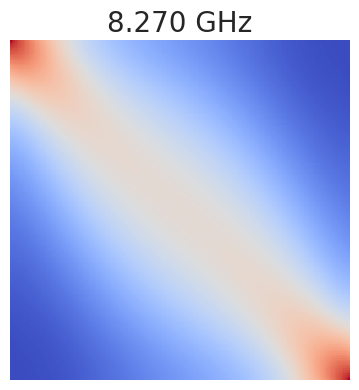

In [11]:
# Plot the eigenvalue amplitudes in the 3d space. por P(x)P(y)P(z) basis

# select work set
fv = fr_full.copy()
vals = eig_vals_full.copy()
vects = eig_vects_full.copy()
base = c_full.copy()

# new grid()
xs = ys = np.linspace(-1, 1, 201)
zs = [0]

# Coordinates of the grid:
Xg, Yg, Zg = np.meshgrid(xs, ys, zs, indexing='ij')

# mode to plot
f_i = 0
fs_hi = np.real(vals/(2j*np.pi))
fi = np.abs(fs_hi - fv[f_i]).argmin()
print('Fr = %0.3f GHz' % (fs_hi[fi]/1E9))

# Get the vector
e_vect_in_P = vects[:, fi].reshape([base.shape[-1], 3])
e_vect3d = legval3d(Xg, Yg, Zg, base @ e_vect_in_P)

plotData = np.abs((e_vect3d[1, :, :, 0]))

plt.close('Mode X')
fig = plt.figure('Mode X', (6, 4))
plt.imshow(plotData.T,
           origin='lower',
           cmap='coolwarm',
           interpolation='none',
           aspect=1
           )
plt.title('%0.3f GHz' % (fs_hi[fi]/1E9))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
